# Lasso Regression

This note introduces the **Lasso Regression** algorithm using `scikit-learn`, explains the step-by-step logic behind how it works, and then demonstrates a from-scratch implementation to show that the core idea is simple and easy to build.

## What is Lasso Regression?

Lasso Regression is like **Linear Regression with a built-in feature selector**.

It still aims to draw the best line through the data, but it also **penalizes the absolute values of the coefficients**. This means it can **shrink some weights to exactly zero**, effectively removing unimportant features from the model.

This helps prevent overfitting, especially when dealing with **many features**, and results in a simpler, more interpretable model.

This notebook will:

- Use `scikit-learn` to demonstrate how Lasso Regression works in practice  
- Explain the logic behind it in an intuitive way  
- Show how to implement the same idea step by step from scratch  

Let’s dive into the details to understand how it works and how to implement it ourselves.

## Preparation

Before we apply Lasso Regression, let’s create a dataset that has a **nonlinear trend**, **redundant features**, and some **random noise** — so we can see how regularization and feature selection come into play.

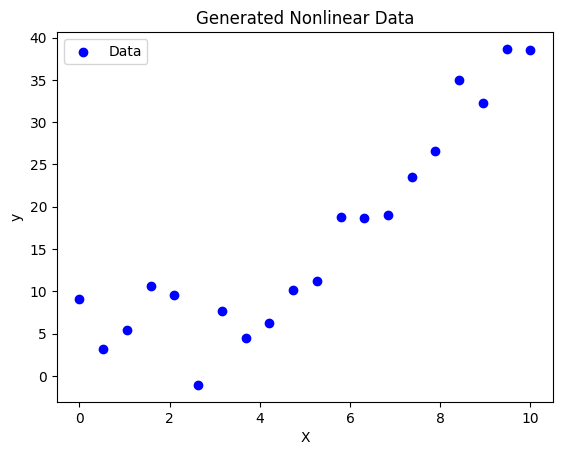

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Create nonlinear data
np.random.seed(0)
X = np.linspace(0, 10, 20).reshape(-1, 1)
y = 0.5 * X**2 - X + 2 + np.random.randn(20, 1) * 4  # add noise

# Visualize the data
plt.scatter(X, y, color='blue', label='Data')
plt.title("Generated Nonlinear Data")
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.show()

## Implement with Scikit-Learn

We’ll now use `scikit-learn` to fit a **Lasso Regression model** on a **small, noisy dataset**.

Because the relationship is nonlinear, we’ll first expand the input features using **PolynomialFeatures**. Then we’ll apply **Lasso Regression** to see how regularization helps simplify the model — especially by **shrinking some coefficients to zero** when the polynomial degree is high.

We’ll compare two models:

- A standard **Polynomial Regression** (which tends to overfit with small data)  
- A **Lasso-regularized Polynomial Regression** (which smooths and sparsifies the curve)

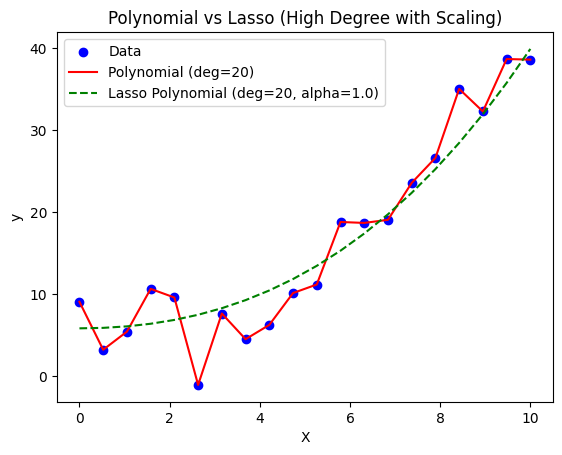

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso

degree = 50

# Without Lasso (standard polynomial)
poly_model = make_pipeline(PolynomialFeatures(degree), StandardScaler(), LinearRegression())
poly_model.fit(X, y)
y_pred_poly = poly_model.predict(X)

# With Lasso (strong regularization)
lasso_model = make_pipeline(PolynomialFeatures(degree), StandardScaler(), Lasso(alpha=1.0, max_iter=10000))
lasso_model.fit(X, y)
y_pred_lasso = lasso_model.predict(X)

# Plot
plt.scatter(X, y, color='blue', label='Data')
plt.plot(X, y_pred_poly, color='red', label='Polynomial (deg=20)')
plt.plot(X, y_pred_lasso, color='green', linestyle='--', label='Lasso Polynomial (deg=20, alpha=1.0)')
plt.title("Polynomial vs Lasso (High Degree with Scaling)")
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.show()

## Understanding the Visualization

The plot above shows how two models behave when trained on just **20 data points** with visible noise.

- The red line is **standard Polynomial Regression** (degree 20)  
- The green dashed line is **Polynomial + Lasso Regression** (degree 20, alpha=1.0)

Both models use the same high-degree polynomial, but Lasso applies **regularization** that not only smooths the curve — it can also **eliminate unnecessary features entirely** by setting their weights to zero.

## Behind the Scenes

### 1. Polynomial Features = Curve-Friendly Input

A normal linear model like:

$$
\hat{y} = w_0 + w_1 x
$$

can only fit a straight line. To model curves, we expand the input:

$$
x \rightarrow [1, x, x^2, x^3, \dots, x^d]
$$

So the model becomes:

$$
\hat{y} = w_0 + w_1 x + w_2 x^2 + \dots + w_d x^d
$$

This gives the model more flexibility to follow curved patterns in the data.

Even though the output is nonlinear in $x$, it is still **linear in the weights**, so we can train it using linear regression techniques.

### 2. Why Regularization?

With just 20 points and a 20-degree polynomial, the model can easily **overfit** — creating a wiggly curve that tries to hit every noisy point.

**Lasso Regression** prevents this by adding a **penalty on the absolute values of the weights**.  
This penalty encourages many weights to shrink — and some to shrink **all the way to zero**.

The loss function becomes:

$$
\text{Loss} = \frac{1}{2n} \sum_{i=1}^n (\hat{y}_i - y_i)^2 + \alpha \sum_{j=1}^d |w_j|
$$

This second term:

$$
\alpha \sum |w_j|
$$

is what gives Lasso its special power:  
→ **It doesn’t just shrink weights — it can eliminate them entirely.**

So Lasso acts like a **built-in feature selector**.

### 3. How does it push the weights?

Lasso adds a **soft-thresholding effect** during training.

If we use **gradient descent**, the update is more complex than Ridge due to the **non-differentiable** point at 0. But the idea is:

- If the weight is small enough, it gets **pushed to zero**
- Larger weights are pulled closer to zero, but not always eliminated

This creates **sparsity** — a lot of the $w_j$ values become exactly 0.

This behavior is different from Ridge, which **shrinks** all weights but never removes them completely.

> The result: A **simpler model** that only keeps the most relevant polynomial terms.

### 4. Why Scale Polynomial Features?

Polynomial features like $x^2$, $x^5$, or $x^{20}$ can differ wildly in scale.

Without scaling, the Lasso penalty might disproportionately affect features with larger values — even if they’re important.

That’s why we **standardize** the features (mean 0, std 1), but we **don’t regularize the bias** term (the constant 1).

> Scaling makes Lasso regularization more fair and effective across all degrees.

### 5. What happens when weights shrink to zero?

Each weight controls how much the model bends:

- $w_1$ controls the slope  
- $w_2$ controls the basic curve  
- Higher-degree terms control finer twists and wiggles

When Lasso shrinks a weight to **zero**, it’s like removing that curve from the model entirely.

So instead of trying to fit every bump in the data:

- Lasso **removes unnecessary twists**  
- The model focuses on the **main trend**  
- And we end up with a **simpler, more interpretable** model

> This is why Lasso is especially useful when you have **many features** or **high-degree polynomials** — it filters out the noise.

## Let’s Code It

Now let’s implement **Polynomial Regression with Lasso Regularization** from scratch using **gradient descent**,  
since Lasso’s absolute value penalty makes closed-form solutions harder.

We’ll follow these main steps:

1. Expand the input into **polynomial features**  
2. Standardize the features (except the bias)  
3. Use **gradient descent** to minimize the Lasso loss:

$$
\text{Loss} = \frac{1}{2n} \sum_{i=1}^n (\hat{y}_i - y_i)^2 + \alpha \sum_{j=1}^d |w_j|
$$

This will give us weights that **fit the data well**, while **automatically pruning** unimportant terms.

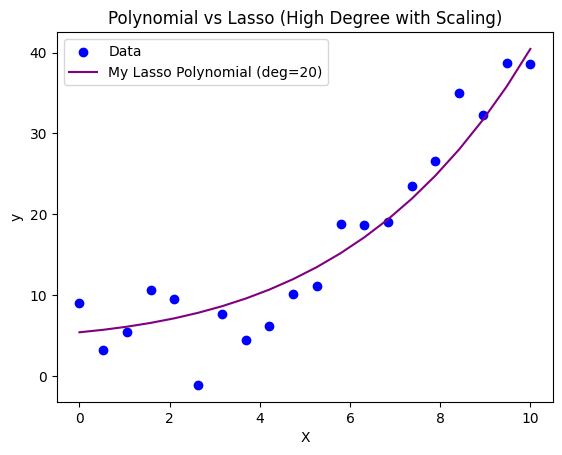

In [ ]:
# Expand input X into polynomial features [1, x, x^2, ..., x^d]
def add_polynomial_features(X, degree):
    if X.ndim == 1:
        X = X.reshape(-1, 1)

    features = [np.ones((X.shape[0], 1))]  # Bias term = column of 1s
    if degree >= 1:
        features.append(X)  # x^1

    for d in range(2, degree + 1):
        features.append(X**d)  # x^2 to x^d

    return np.hstack(features)

# Lasso Regression using gradient descent on polynomial features
class MyLassoPolynomialRegression:
    def __init__(self, degree=2, alpha=1.0, learning_rate=0.01, max_iter=1000, tol=1e-6):
        self.degree = degree                 # Degree of polynomial
        self.alpha = alpha                   # Regularization strength (L1)
        self.lr = learning_rate              # Step size for gradient descent
        self.max_iter = max_iter             # Max iterations for training
        self.tol = tol                       # Convergence threshold
        self.coef_ = None                    # To store trained weights
        self.scaler = StandardScaler()       # Only scale non-bias features

    def fit(self, X, y):
        if X.ndim == 1:
            X = X.reshape(-1, 1)
        y = y.reshape(-1, 1)  # Ensure y is column vector

        # 1. Expand input into [1, x, x^2, ..., x^d]
        X_poly = add_polynomial_features(X, self.degree)

        # 2. Separate bias (1st column) from polynomial features
        X_bias = X_poly[:, 0:1]         # shape = (n_samples, 1)
        X_features = X_poly[:, 1:]      # shape = (n_samples, degree)

        # 3. Standardize polynomial features (not the bias)
        if X_features.shape[1] > 0:
            X_features_scaled = self.scaler.fit_transform(X_features)
            X_ready = np.hstack([X_bias, X_features_scaled])  # Combine scaled features with bias
        else:
            X_ready = X_bias  # Only bias column if degree = 0

        # 4. Initialize weights (all zeros)
        n_samples, n_features = X_ready.shape
        w = np.zeros((n_features, 1))
        prev_cost = float('inf')

        # 5. Gradient Descent Loop
        for i in range(self.max_iter):
            # Prediction: ŷ = Xw
            y_pred = X_ready @ w
            error = y_pred - y

            # Compute Mean Squared Error
            mse = (1 / (2 * n_samples)) * np.sum(error**2)

            # Compute L1 penalty term: sum of absolute weights (excluding bias term)
            l1_penalty = self.alpha * np.sum(np.abs(w[1:]))

            # Total cost = MSE + L1 penalty
            cost = mse + l1_penalty

            # Stop if cost improvement is smaller than threshold
            if abs(prev_cost - cost) < self.tol:
                print(f"Converged at iteration {i}, cost: {cost:.6f}")
                break
            prev_cost = cost

            # Gradient of MSE: ∂J/∂w = (1/n) * Xᵀ (ŷ - y)
            grad = (1 / n_samples) * (X_ready.T @ error)

            # Subgradient of L1: sign(w), excluding bias (w[0])
            # sign(w_j) = +1 if w_j > 0, -1 if w_j < 0, 0 if w_j == 0
            l1_grad = np.zeros_like(w)
            l1_grad[1:] = self.alpha * np.sign(w[1:])  # no regularization on bias

            # Update weights: w := w - η * (grad + L1_grad)
            w -= self.lr * (grad + l1_grad)

        # Save the learned weights
        self.coef_ = w

    def predict(self, X):
        if X.ndim == 1:
            X = X.reshape(-1, 1)

        # Recreate polynomial features
        X_poly = add_polynomial_features(X, self.degree)
        X_bias = X_poly[:, 0:1]
        X_features = X_poly[:, 1:]

        # Apply same scaling to test data (as fit)
        if X_features.shape[1] > 0:
            X_features_scaled = self.scaler.transform(X_features)
            X_ready = np.hstack([X_bias, X_features_scaled])
        else:
            X_ready = X_bias

        # Predict using learned weights
        return X_ready @ self.coef_

# Train and plot
model_my = MyLassoPolynomialRegression(degree=20, alpha=1.0)
model_my.fit(X, y)
y_pred_my = model_my.predict(X)

plt.scatter(X, y, color='blue', label='Data')
plt.plot(X, y_pred_my, color='purple', label='My Lasso Polynomial (deg=20)')
plt.title("Polynomial vs Lasso (High Degree with Scaling)")
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.show()

## It Works!!

The curved regression line produced by our from-scratch **Polynomial Regression with Lasso Regularization** closely matches the result from **scikit-learn**.

This confirms that the feature scaling, subgradient updates, and L1 regularization logic behave as expected.

We've successfully built **Polynomial Lasso Regression** from the ground up.